In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pymongo
import os

In [3]:
def con_sql(db_name, dialect=None):
	db_file = Path(db_name)
	if not db_file.is_file():
		print("no such database file: {}".format(db_name))
		return
	if dialect is None:
		return sqlite3.connect(db_name)
	return sqlite3.connect(db_name, dialect)

In [4]:
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()

In [5]:
class Team:
    def __init__(self, name):
        self.name = name
        self.record = []
        self.goals_scored = None
        self.game_dates_and_results_list = None
        self.rainy_day_win_percentage = None

    #Gets a list of tuples of all the dates a team played 
    # and a binary value for whether they won or lost in the format (date, 1) or (date, 0)
    def set_game_dates_and_results_list(self):
        q=("""
        SELECT Date, FTR, HomeTeam, AwayTeam, Season
        FROM Matches 
        WHERE (Season=2011) AND ((HomeTeam='{}') OR (AwayTeam='{}'))
        ORDER BY Date
        """.format(self.name, self.name))

        df = pd.read_sql_query(q, conn)
        date_result_tuple_list = []
        for i, date in enumerate(df.Date):
            if df.FTR[i]=='H' and df.HomeTeam[i]==self.name:
                date_result_tuple_list.append((df.Date[i], 'W'))
            elif df.FTR[i]=='H' and df.HomeTeam[i]!=self.name:
                date_result_tuple_list.append((df.Date[i], 'L'))
            elif df.FTR[i]=='A' and df.AwayTeam[i]==self.name:
                date_result_tuple_list.append((df.Date[i], 'W'))
            elif df.FTR[i]=='A' and df.AwayTeam[i]!=self.name:
                date_result_tuple_list.append((df.Date[i], 'L'))
            else:
                date_result_tuple_list.append((df.Date[i], 'D'))

        self.game_dates_and_results_list = date_result_tuple_list

    #Sets the Team's GOALS SCORED
    def set_goals_scored(self):
        q=("""
        SELECT FTHG, FTAG
        FROM Matches
        WHERE (Season=2011) AND ((HomeTeam='{}') OR (AwayTeam='{}'))
        """.format(self.name, self.name))

        df = pd.read_sql_query(q, conn)
        total_goals = df.FTHG.sum() + df.FTAG.sum()
        self.goals_scored = total_goals

    #Sets the Team's RECORD
    def set_record(self):
        #This finds the wins
        q=("""
        SELECT FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='H') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='A')
        """.format(self.name,self.name))

        wins = pd.read_sql_query(q, conn)
        num_wins = wins.shape[0]

        #This finds the losses
        q=("""
        SELECT FTHG, FTAG, FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='A') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='H')
        """.format(self.name,self.name))

        losses = pd.read_sql_query(q, conn)
        num_losses = losses.shape[0]

        #This finds the drawws
        q=("""
        SELECT FTHG, FTAG, FTR, HomeTeam, AwayTeam, Season  
        FROM Matches
        WHERE ((Season=2011) AND (HomeTeam='{}')) AND (FTR='D') OR ((Season=2011) AND (AwayTeam='{}')) AND (FTR='D')
        """.format(self.name,self.name))

        draws = pd.read_sql_query(q, conn)
        num_draws = draws.shape[0]
        
        record_list = [num_wins,num_losses,num_draws]
        
        self.record.append(num_wins)
        self.record.append(num_losses)
        self.record.append(num_draws)

    def set_name(self, name):
        self.name = name
        




In [6]:
#Gets a list of all the teams that played in the 2011 season
def get_team_list():
        q=("""
        SELECT TeamName  
        FROM Unique_Teams u
        JOIN Matches m
        WHERE (u.TeamName=m.HomeTeam) OR (u.TeamName=m.AwayTeam) AND (m.Season=2011)
        """)
        df = pd.read_sql_query(q, conn)
        df.drop_duplicates('TeamName', inplace=True)
        
        team_name_list = list(df.TeamName)
        team_name_list.remove("M'gladbach")
        team_name_list.remove("M'Gladbach")
        team_name_list.remove("Nott'm Forest")
        
        return team_name_list

In [7]:
team_list = get_team_list()

In [8]:
list_of_team_objects = []
for team in team_list:
    locals()[team.replace(' ', '_')] = Team(team)
    list_of_team_objects.append(locals()[team.replace(' ', '_')])

In [9]:
for team in list_of_team_objects:
    team.set_game_dates_and_results_list()
    team.set_record()
    team.set_goals_scored()
    

images/Bayern_Munich.png
images/Dortmund.png
images/Leverkusen.png
images/RB_Leipzig.png
images/Schalke_04.png
images/Wolfsburg.png
images/FC_Koln.png
images/Hoffenheim.png
images/Hertha.png
images/Mainz.png
images/Hamburg.png
images/Werder_Bremen.png
images/Ein_Frankfurt.png
images/Augsburg.png
images/Freiburg.png
images/Stuttgart.png
images/Hannover.png
images/Ingolstadt.png
images/Darmstadt.png
images/Paderborn.png
images/Nurnberg.png
images/Braunschweig.png
images/Greuther_Furth.png
images/Fortuna_Dusseldorf.png
images/Kaiserslautern.png
images/St_Pauli.png
images/Bochum.png
images/Karlsruhe.png
images/Bielefeld.png
images/Cottbus.png
images/Duisburg.png
images/Hansa_Rostock.png
images/Aachen.png
images/Union_Berlin.png
images/Heidenheim.png
images/Dresden.png
images/Sandhausen.png
images/Erzgebirge_Aue.png
images/Kiel.png
images/Regensburg.png
images/Munich_1860.png
images/Wurzburger_Kickers.png
images/Frankfurt_FSV.png
images/Aalen.png
images/Oberhausen.png
images/Osnabruck.png
i

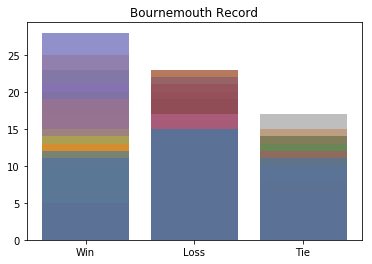

In [10]:
image_path_list = []
for team in list_of_team_objects:
    objects = ('Win','Loss','Tie')
    performance = [team.record[0], team.record[1], team.record[2]]

    plt.bar(objects, performance, align='center', alpha=0.5)
    plt.xticks(objects)
    plt.title(f'{team.name} Record')

    team_name = team.name.replace(' ','_') +'.png'
    file_name=os.path.join('images', team_name)
    image_path_list.append(file_name)
    print(file_name)
    plt.savefig(file_name)
    

images/Bayern_Munich.png


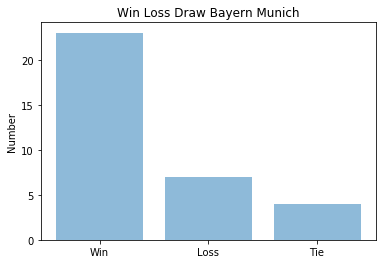

<Figure size 432x288 with 0 Axes>

In [11]:
objects = ('Win','Loss','Tie')
performance = [Bayern_Munich.record[0], Bayern_Munich.record[1], Bayern_Munich.record[2]]

plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(objects)
plt.ylabel('Number')
plt.title(f'Win Loss Draw {Bayern_Munich.name}')

team_name = Bayern_Munich.name.replace(' ','_') +'.png'
file_name=os.path.join('images', team_name)
print(file_name)
plt.show()
plt.savefig(file_name)


In [25]:
class MongoHandler():
    def __init__(self, db_name, collection_name):
        self.db_name = db_name
        self.collection_name = collection_name
        
        
    def initialize_database(self):
        myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.db_name = myclient[self.db_name]
        self.collection_name = self.db_name[self.collection_name]
    
    def add_records(self, list_of_team_objects, image_path_list):  
        team_records = []
        for index, team in enumerate(list_of_team_objects):
            #if not self.collection_name.find({'name': team.name}):
                team_data = {'name': team.name, 'record': team.record, 'goals_scored': int(team.goals_scored),
                            'win_loss_histgram' : image_path_list[index], 
                             'rainy_day_win_percentage' : team.rainy_day_win_percentage}
                team_records.append(team_data)
        if len(team_records)>=1:
            self.collection_name.insert_many(team_records)
        
    def read_one_record(self, team):
        query_list = []
        query = self.collection_name.find({'name': team.name})
        
        for item in query:
            query_list.append(item)
            
        return query_list
            
    def read_multiple_records(self, list_of_teams):
        list_of_records = []
        for team in list_of_teams:
            list_of_records.append(self.read_one_record(team))

        return list_of_records
    
    def drop_collection(self):
        self.db_name.drop_collection(self.collection_name)
    

        

In [40]:
SoccerData2.collection_name

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'soccer_db'), 'soccer_collection')

In [39]:
SoccerData2.db_name.drop_collection(SoccerData2.collection_name)

{'ok': 0.0,
 'errmsg': 'ns not found',
 'code': 26,
 'codeName': 'NamespaceNotFound'}

In [29]:

SoccerData2 = MongoHandler('soccer_db', 'soccer_collection')



In [30]:
SoccerData2.initialize_database()



In [31]:
SoccerData2.add_records(list_of_team_objects, image_path_list)


In [32]:
SoccerData2.read_one_record(Bayern_Munich)

[{'_id': ObjectId('5cded87e33a9d5b7a25ee0d3'),
  'name': 'Bayern Munich',
  'record': [23, 7, 4],
  'goals_scored': 99,
  'win_loss_histgram': 'images/Bayern_Munich.png',
  'rainy_day_win_percentage': None}]

In [33]:
SoccerData2.read_multiple_records(list_of_team_objects)




[[{'_id': ObjectId('5cded87e33a9d5b7a25ee0d3'),
   'name': 'Bayern Munich',
   'record': [23, 7, 4],
   'goals_scored': 99,
   'win_loss_histgram': 'images/Bayern_Munich.png',
   'rainy_day_win_percentage': None}],
 [{'_id': ObjectId('5cded87e33a9d5b7a25ee0d4'),
   'name': 'Dortmund',
   'record': [25, 3, 6],
   'goals_scored': 105,
   'win_loss_histgram': 'images/Dortmund.png',
   'rainy_day_win_percentage': None}],
 [{'_id': ObjectId('5cded87e33a9d5b7a25ee0d5'),
   'name': 'Leverkusen',
   'record': [15, 10, 9],
   'goals_scored': 96,
   'win_loss_histgram': 'images/Leverkusen.png',
   'rainy_day_win_percentage': None}],
 [{'_id': ObjectId('5cded87e33a9d5b7a25ee0d6'),
   'name': 'RB Leipzig',
   'record': [0, 0, 0],
   'goals_scored': 0,
   'win_loss_histgram': 'images/RB_Leipzig.png',
   'rainy_day_win_percentage': None}],
 [{'_id': ObjectId('5cded87e33a9d5b7a25ee0d7'),
   'name': 'Schalke 04',
   'record': [20, 10, 4],
   'goals_scored': 118,
   'win_loss_histgram': 'images/Schalke